# Transer Learning

In [14]:
import zipfile
import urllib.request
import random
import os
import pathlib
import datetime
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

In [2]:
# downloading dataset

url = "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip"
filename = "10_food_classes_10_percent.zip"
file = urllib.request.urlretrieve(url, filename)

# unziping dataset

with zipfile.ZipFile("10_food_classes_10_percent.zip") as zip_ref:
    zip_ref.extractall("./data")

In [4]:
for dirpath, dirnames, filenames in os.walk(
        "./data/10_food_classes_10_percent/"):
    print(len(dirnames), len(filenames), dirpath)


2 0 ./data/10_food_classes_10_percent/
10 0 ./data/10_food_classes_10_percent/test
0 250 ./data/10_food_classes_10_percent/test/ice_cream
0 250 ./data/10_food_classes_10_percent/test/chicken_curry
0 250 ./data/10_food_classes_10_percent/test/steak
0 250 ./data/10_food_classes_10_percent/test/sushi
0 250 ./data/10_food_classes_10_percent/test/chicken_wings
0 250 ./data/10_food_classes_10_percent/test/grilled_salmon
0 250 ./data/10_food_classes_10_percent/test/hamburger
0 250 ./data/10_food_classes_10_percent/test/pizza
0 250 ./data/10_food_classes_10_percent/test/ramen
0 250 ./data/10_food_classes_10_percent/test/fried_rice
10 0 ./data/10_food_classes_10_percent/train
0 75 ./data/10_food_classes_10_percent/train/ice_cream
0 75 ./data/10_food_classes_10_percent/train/chicken_curry
0 75 ./data/10_food_classes_10_percent/train/steak
0 75 ./data/10_food_classes_10_percent/train/sushi
0 75 ./data/10_food_classes_10_percent/train/chicken_wings
0 75 ./data/10_food_classes_10_percent/train/gril

## prepare data loaders

In [22]:
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "./data/10_food_classes_10_percent/train/"
test_dir = "./data/10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1 / 255.)
test_datagen = ImageDataGenerator(rescale=1 / 255.)

print("training images:")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical")

print("testing images:")
test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical")


training images:
Found 750 images belonging to 10 classes.
testing images:
Found 2500 images belonging to 10 classes.


## setting up callbacks

In [35]:
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now(
    ).strftime("%Y%m%d-%H%M%S")

    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"saving tensorboard log files to: {log_dir}")
    
    return tensorboard_callback

[tf.hub.dev](https://tfhub.dev)

In [16]:

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [41]:
def create_model(model_url, num_classes=10):
    feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable=False,  #Freeze learned patterns
        name="feature_extraction_layer",
        input_shape=IMAGE_SHAPE + (3,))

    model = tf.keras.Sequential([
        feature_extractor_layer,
        tf.keras.layers.Dense(num_classes,
                              activation="softmax",
                              name="output_layer")])

    return model


In [42]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)


In [43]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [44]:
resnet_model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [47]:
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[
                                      create_tensorboard_callback(
                                          dir_name="tensorflow_hub",
                                          experiment_name="resnet50V2")
                                  ])


saving tensorboard log files to: tensorflow_hub/resnet50V2/20230217-170021
Epoch 1/5
24/24 [==============================] - 224s 10s/step - loss: 0.9101 - accuracy: 0.7373 - val_loss: 0.8299 - val_accuracy: 0.7392
Epoch 2/5
24/24 [==============================] - 220s 9s/step - loss: 0.6262 - accuracy: 0.8253 - val_loss: 0.7509 - val_accuracy: 0.7592
Epoch 3/5
24/24 [==============================] - 289s 12s/step - loss: 0.4984 - accuracy: 0.8773 - val_loss: 0.7086 - val_accuracy: 0.7724
Epoch 4/5
24/24 [==============================] - 221s 9s/step - loss: 0.3926 - accuracy: 0.9107 - val_loss: 0.6640 - val_accuracy: 0.7872
Epoch 5/5
24/24 [==============================] - 226s 10s/step - loss: 0.3192 - accuracy: 0.9320 - val_loss: 0.6513 - val_accuracy: 0.7900


In [48]:
def plot_loss_curves(history):
    """
  Returns separate loss curves for training and validation metrics.
  """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

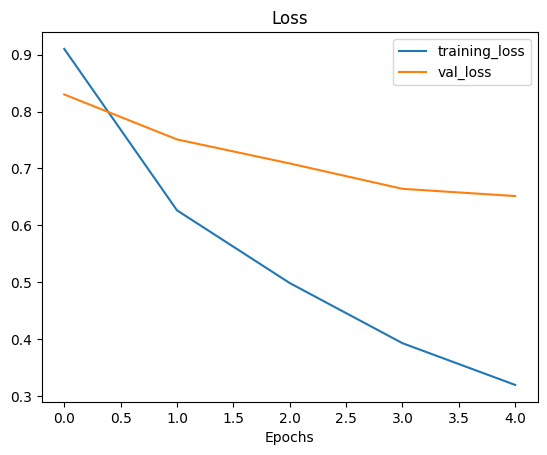

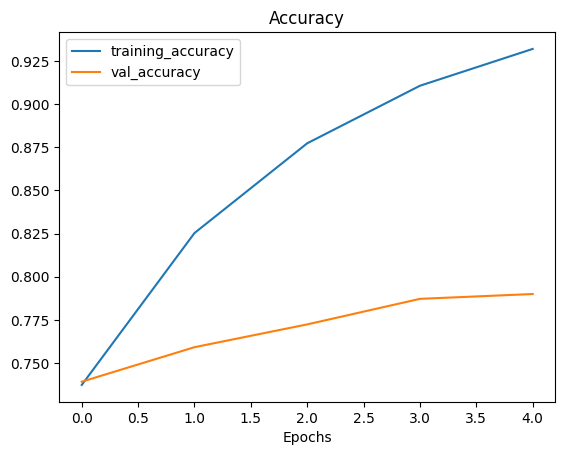

In [49]:
plot_loss_curves(resnet_history)

In [50]:
efficientnet_model = create_model(
    model_url=efficientnet_url, num_classes=train_data_10_percent.num_classes)

efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[
                                      create_tensorboard_callback(
                                          dir_name="tensorflow_hub",
                                          experiment_name="efficientnetb0")
                                  ])

saving tensorboard log files to: tensorflow_hub/efficientnetb0/20230217-172120
Epoch 1/5
24/24 [==============================] - 139s 6s/step - loss: 1.7687 - accuracy: 0.4880 - val_loss: 1.2580 - val_accuracy: 0.7484
Epoch 2/5
24/24 [==============================] - 123s 5s/step - loss: 1.0282 - accuracy: 0.7773 - val_loss: 0.8490 - val_accuracy: 0.8196
Epoch 3/5
24/24 [==============================] - 122s 5s/step - loss: 0.7378 - accuracy: 0.8307 - val_loss: 0.6912 - val_accuracy: 0.8440
Epoch 4/5
24/24 [==============================] - 126s 5s/step - loss: 0.5996 - accuracy: 0.8707 - val_loss: 0.6083 - val_accuracy: 0.8540
Epoch 5/5
24/24 [==============================] - 123s 5s/step - loss: 0.5040 - accuracy: 0.8867 - val_loss: 0.5575 - val_accuracy: 0.8664


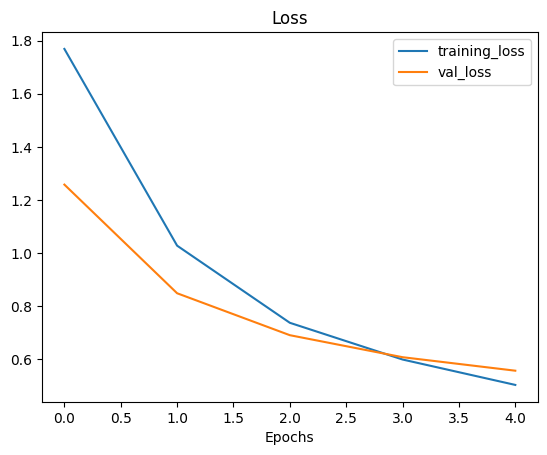

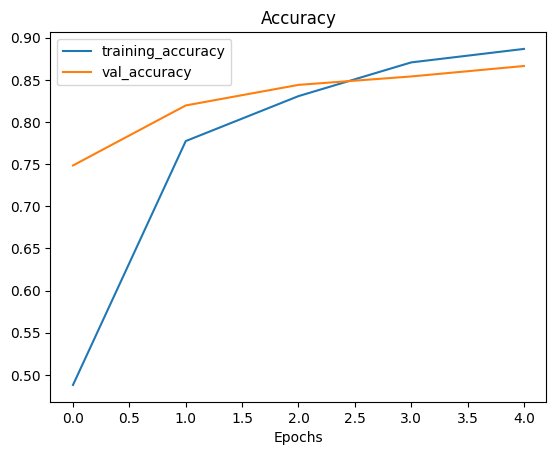

In [51]:
plot_loss_curves(efficientnet_history)